# Synthetic Data without interaction: recovery of relevant features

## Generate synthetic datasets

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from ignite.utils import manual_seed
from pyselect.synthesizer import make_regression_with_tensors, train_val_test_split

### Make regression dataset

In [2]:
n_features = 100
n_informative = 100

In [3]:
train_size = 4000
val_size = 1000
test_size = 1000

In [4]:
manual_seed(0)

In [5]:
X_mr, y_mr, coef_mr = make_regression_with_tensors(n_samples=6000, n_features=n_features, n_informative=n_informative)

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_mr, y_mr, train_size, val_size, test_size)


Datasets

In [7]:
train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)
test = torch.utils.data.TensorDataset(X_test, y_test)

Dataloaders

In [8]:
train_loader = DataLoader(train, batch_size=200)
val_loader = DataLoader(val, batch_size=200)
test_loader = DataLoader(test, batch_size=100)

## Applying our method

In [9]:
import optuna
import torch.nn as nn
import torch.optim as optim
from optuna.samplers import TPESampler
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RootMeanSquaredError
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.synthesizer import train_val_test_split

Loss function

In [10]:
def ridge_loss(y_pred, y_true, model, reg_param):
    weights = model.rff_net[2].weight.squeeze()
    loss = torch.mean(torch.square(y_pred-y_true)) + reg_param * weights.dot(weights)
    return loss

Score function for early stopping

In [11]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

Optuna callback to save best model

In [12]:
def best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['best_model'])

Objective for optuna

In [13]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    out_features = 600
    model = RandomFourierFeaturesNet(n_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-2, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 300
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Initialize optuna study

In [14]:
tpe_sampler = TPESampler(seed=0)

In [15]:
study = optuna.create_study(direction='minimize', sampler=tpe_sampler)

[I 2022-02-19 16:40:31,763] A new study created in memory with name: no-name-3468a314-ece2-4fa4-be1c-b28680314b52


In [16]:
n_epochs = 1050

In [17]:
study.optimize(objective, n_trials=40, callbacks=[best_model_callback])

Training - Epoch: 300 Loss: 50.56089
Validation - Epoch: 300 Loss: 51.72815
Learning rate: 0.0125
Training - Epoch: 600 Loss: 28.75863
Validation - Epoch: 600 Loss: 30.13636
Learning rate: 0.0063
Training - Epoch: 900 Loss: 25.19784
Validation - Epoch: 900 Loss: 26.57091
Learning rate: 0.0063


[I 2022-02-19 16:41:17,442] Trial 0 finished with value: 19.841857421875 and parameters: {'learning_rate': 0.012520653814999465, 'reg_param': 0.0003766576841599299}. Best is trial 0 with value: 19.841857421875.


Training - Epoch: 300 Loss: 58.40847
Validation - Epoch: 300 Loss: 59.14830
Learning rate: 0.0161
Training - Epoch: 600 Loss: 30.08787
Validation - Epoch: 600 Loss: 31.19465
Learning rate: 0.0080
Training - Epoch: 900 Loss: 28.89328
Validation - Epoch: 900 Loss: 31.20002
Learning rate: 0.0080


[I 2022-02-19 16:42:01,563] Trial 1 finished with value: 19.616947265625 and parameters: {'learning_rate': 0.01605191133358762, 'reg_param': 5.301709347576825e-05}. Best is trial 1 with value: 19.616947265625.


Training - Epoch: 300 Loss: 49.69160
Validation - Epoch: 300 Loss: 49.50610
Learning rate: 0.0070
Training - Epoch: 600 Loss: 27.40728
Validation - Epoch: 600 Loss: 26.90428
Learning rate: 0.0035
Training - Epoch: 900 Loss: 22.00762
Validation - Epoch: 900 Loss: 21.39366
Learning rate: 0.0035


[I 2022-02-19 16:42:47,135] Trial 2 finished with value: 18.004099609375 and parameters: {'learning_rate': 0.00703573702872215, 'reg_param': 0.00016961746387290997}. Best is trial 2 with value: 18.004099609375.


Training - Epoch: 300 Loss: 57.90415
Validation - Epoch: 300 Loss: 56.22927
Learning rate: 0.0075
Training - Epoch: 600 Loss: 45.87975
Validation - Epoch: 600 Loss: 45.45312
Learning rate: 0.0038
Training - Epoch: 900 Loss: 43.35040
Validation - Epoch: 900 Loss: 43.22523
Learning rate: 0.0038


[I 2022-02-19 16:43:31,289] Trial 3 finished with value: 42.0295546875 and parameters: {'learning_rate': 0.007501954443620123, 'reg_param': 0.0028765041432547}. Best is trial 2 with value: 18.004099609375.


Training - Epoch: 300 Loss: 141.10862
Validation - Epoch: 300 Loss: 137.51127
Learning rate: 0.0846
Training - Epoch: 600 Loss: 136.73053
Validation - Epoch: 600 Loss: 138.54438
Learning rate: 0.0423
Training - Epoch: 900 Loss: 139.27520
Validation - Epoch: 900 Loss: 137.72728
Learning rate: 0.0423


[I 2022-02-19 16:44:15,679] Trial 4 finished with value: 137.807859375 and parameters: {'learning_rate': 0.08459126528049378, 'reg_param': 8.264328927007728e-06}. Best is trial 2 with value: 18.004099609375.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:44:28,178] Trial 5 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 141.87847


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:44:40,725] Trial 6 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 80.70613


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:44:53,867] Trial 7 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 95.10723


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:45:06,933] Trial 8 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 103.25163


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:45:20,393] Trial 9 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 142.68370


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:45:33,026] Trial 10 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 64.72443
Training - Epoch: 300 Loss: 55.97936
Validation - Epoch: 300 Loss: 54.87168
Learning rate: 0.0051


Engine run is terminating due to exception: Trial was pruned at 600 epoch.
Engine run is terminating due to exception: Trial was pruned at 600 epoch.
[I 2022-02-19 16:45:58,109] Trial 11 pruned. Trial was pruned at 600 epoch.


Training - Epoch: 600 Loss: 35.65575


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:46:10,512] Trial 12 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 74.37413


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:46:23,685] Trial 13 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 63.37898


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:46:36,206] Trial 14 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 145.86481


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:46:48,279] Trial 15 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 54.79179


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:47:01,165] Trial 16 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 82.11056


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:47:13,697] Trial 17 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 65.35551


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:47:26,503] Trial 18 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 141.01125
Training - Epoch: 300 Loss: 48.63086
Validation - Epoch: 300 Loss: 50.62297
Learning rate: 0.0089
Training - Epoch: 600 Loss: 22.57555
Validation - Epoch: 600 Loss: 23.10376
Learning rate: 0.0045
Training - Epoch: 900 Loss: 18.85706
Validation - Epoch: 900 Loss: 19.68620
Learning rate: 0.0045


[I 2022-02-19 16:48:11,579] Trial 19 finished with value: 16.251537109375 and parameters: {'learning_rate': 0.008911420020417601, 'reg_param': 2.333050352373727e-07}. Best is trial 19 with value: 16.251537109375.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:48:24,447] Trial 20 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 69.55872
Training - Epoch: 300 Loss: 45.30788
Validation - Epoch: 300 Loss: 45.02454
Learning rate: 0.0094
Training - Epoch: 600 Loss: 21.51199
Validation - Epoch: 600 Loss: 21.34627
Learning rate: 0.0047
Training - Epoch: 900 Loss: 17.81588
Validation - Epoch: 900 Loss: 17.60664
Learning rate: 0.0047


[I 2022-02-19 16:49:08,622] Trial 21 finished with value: 15.49398828125 and parameters: {'learning_rate': 0.009389012227055793, 'reg_param': 1.0143749613491138e-07}. Best is trial 21 with value: 15.49398828125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:49:21,552] Trial 22 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 50.34725
Training - Epoch: 300 Loss: 50.85816
Validation - Epoch: 300 Loss: 50.81256
Learning rate: 0.0055
Training - Epoch: 600 Loss: 30.24988
Validation - Epoch: 600 Loss: 29.88695
Learning rate: 0.0027
Training - Epoch: 900 Loss: 23.79538
Validation - Epoch: 900 Loss: 23.43186
Learning rate: 0.0027


Engine run is terminating due to exception: Trial was pruned at 1050 epoch.
[I 2022-02-19 16:50:06,418] Trial 23 pruned. Trial was pruned at 1050 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:50:18,815] Trial 24 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 50.80032


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:50:32,754] Trial 25 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 57.76356
Training - Epoch: 300 Loss: 49.91059
Validation - Epoch: 300 Loss: 50.04491
Learning rate: 0.0096
Training - Epoch: 600 Loss: 25.66454
Validation - Epoch: 600 Loss: 25.85108
Learning rate: 0.0048
Training - Epoch: 900 Loss: 20.24585
Validation - Epoch: 900 Loss: 20.89719
Learning rate: 0.0048


[I 2022-02-19 16:51:17,496] Trial 26 finished with value: 17.562185546875 and parameters: {'learning_rate': 0.00963114070979157, 'reg_param': 1.0155742820560625e-06}. Best is trial 21 with value: 15.49398828125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:51:29,399] Trial 27 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 140.02623


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:51:41,234] Trial 28 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 82.94563


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:51:53,024] Trial 29 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 53.43901


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:52:05,022] Trial 30 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 53.24296
Training - Epoch: 300 Loss: 45.57379
Validation - Epoch: 300 Loss: 46.51114
Learning rate: 0.0074
Training - Epoch: 600 Loss: 25.74647
Validation - Epoch: 600 Loss: 26.18328
Learning rate: 0.0037
Training - Epoch: 900 Loss: 22.13627
Validation - Epoch: 900 Loss: 22.85919
Learning rate: 0.0037


[I 2022-02-19 16:52:49,617] Trial 31 finished with value: 18.0251171875 and parameters: {'learning_rate': 0.0073708436332105874, 'reg_param': 0.00014362315140572016}. Best is trial 21 with value: 15.49398828125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:53:01,455] Trial 32 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 49.02038
Training - Epoch: 300 Loss: 47.97919
Validation - Epoch: 300 Loss: 49.34614
Learning rate: 0.0060


Engine run is terminating due to exception: Trial was pruned at 600 epoch.
Engine run is terminating due to exception: Trial was pruned at 600 epoch.
[I 2022-02-19 16:53:26,076] Trial 33 pruned. Trial was pruned at 600 epoch.


Training - Epoch: 600 Loss: 26.30319


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:53:38,710] Trial 34 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 88.08211
Training - Epoch: 300 Loss: 45.11629
Validation - Epoch: 300 Loss: 46.69516
Learning rate: 0.0087
Training - Epoch: 600 Loss: 23.19020
Validation - Epoch: 600 Loss: 23.21230
Learning rate: 0.0044
Training - Epoch: 900 Loss: 21.57480
Validation - Epoch: 900 Loss: 22.00227
Learning rate: 0.0044


[I 2022-02-19 16:54:21,678] Trial 35 finished with value: 16.409041015625 and parameters: {'learning_rate': 0.008746925112226226, 'reg_param': 6.00207969899466e-06}. Best is trial 21 with value: 15.49398828125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:54:33,735] Trial 36 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 143.40155


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:54:46,170] Trial 37 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 73.63216
Training - Epoch: 300 Loss: 45.08384
Validation - Epoch: 300 Loss: 46.40184
Learning rate: 0.0091
Training - Epoch: 600 Loss: 23.02671
Validation - Epoch: 600 Loss: 23.67454
Learning rate: 0.0045
Training - Epoch: 900 Loss: 20.45974
Validation - Epoch: 900 Loss: 21.14689
Learning rate: 0.0045


[I 2022-02-19 16:55:31,122] Trial 38 finished with value: 14.5587861328125 and parameters: {'learning_rate': 0.009077699984373732, 'reg_param': 8.963073703134118e-06}. Best is trial 38 with value: 14.5587861328125.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:55:42,847] Trial 39 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 59.76045


Get best model

In [18]:
best_model = study.user_attrs['best_model']

In [19]:
torch.save(best_model.state_dict(), '../models/make-regression-all-relevant.pth')

Replicate best model on different test datasets

In [20]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test, _ = make_regression_with_tensors(n_samples=test_size, n_features=n_features,
                                                  n_informative=n_informative)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    test_metric = {'rmse': RootMeanSquaredError()}    
    test_evaluator = create_supervised_evaluator(best_model, metrics=test_metric, device=device)
    
    # Final evaluation
    test_evaluator.run(test_loader)
    test_rmse = test_evaluator.state.metrics['rmse']
    
    return test_rmse

In [21]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-19 16:55:42,884] A new study created in memory with name: no-name-f580bbc3-dae7-4d90-918e-287cb44a24c1


In [22]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-19 16:55:42,902] Trial 0 finished with value: 14.825750402593455 and parameters: {}. Best is trial 0 with value: 14.825750402593455.
[I 2022-02-19 16:55:42,911] Trial 1 finished with value: 15.447706140395084 and parameters: {}. Best is trial 0 with value: 14.825750402593455.
[I 2022-02-19 16:55:42,920] Trial 2 finished with value: 14.604758963262626 and parameters: {}. Best is trial 2 with value: 14.604758963262626.
[I 2022-02-19 16:55:42,930] Trial 3 finished with value: 13.967649565155906 and parameters: {}. Best is trial 3 with value: 13.967649565155906.
[I 2022-02-19 16:55:42,938] Trial 4 finished with value: 13.204692584456483 and parameters: {}. Best is trial 4 with value: 13.204692584456483.
[I 2022-02-19 16:55:42,946] Trial 5 finished with value: 14.288482030992656 and parameters: {}. Best is trial 4 with value: 13.204692584456483.
[I 2022-02-19 16:55:42,954] Trial 6 finished with value: 15.057255310978823 and parameters: {}. Best is trial 4 with value: 13.204692584

In [23]:
replication.trials_dataframe()['value'].mean()

14.288959248960744

In [24]:
replication.trials_dataframe()['value'].std()

0.8986366219536972

### Visualizing

#### Bands

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
bands = best_model.rff_net[0].bandwidths.to('cpu').detach().numpy()

In [27]:
inf_features = (np.abs(coef_mr) >= 1e-3).ravel()

In [28]:
inf_bands = bands[inf_features]
noninf_bands = bands[~inf_features]

In [29]:
lim = np.abs(bands).max()
bins = np.linspace(-lim * 1.1, lim * 1.1, 40)

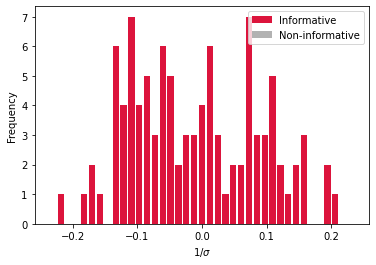

In [30]:
fig = plt.figure()
plt.hist(inf_bands, bins=bins, rwidth=0.8, color="crimson", label="Informative")
plt.hist(
    noninf_bands,
    bins=bins,
    rwidth=0.8,
    color="black",
    alpha=0.3,
    label="Non-informative",
)
plt.xlabel(r"1/$\sigma$")
plt.ylabel("Frequency")
plt.legend(loc="best")
plt.show()

In [31]:
index = np.array(list(range(0, n_features)))
inf_index = index[inf_features]
noninf_index = index[~inf_features]

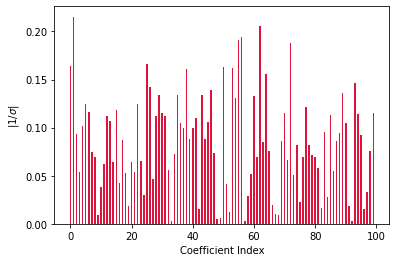

In [37]:
fig = plt.figure()
plt.bar(
    inf_index,
    np.abs(bands[inf_features]),
    color="crimson",
    width=0.5,
    label="Informative",
)
plt.bar(
    noninf_index,
    np.abs(bands[~inf_features]),
    color="black",
    alpha=0.4,
    label="Non-informative",
)
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
plt.show()

In [34]:
model_linear_weights = best_model.rff_net[2].weight.to('cpu').detach().numpy().ravel()

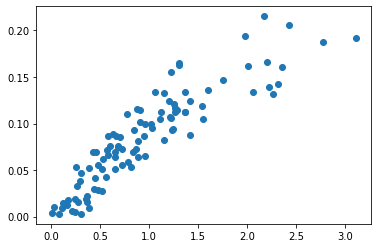

In [35]:
plt.plot(np.abs(coef_mr[inf_features]), np.abs(bands[inf_features]), 'o')
plt.show()